## PyMC3 Memo

#### Model Context

In PyMC3, we typically handle all variables we want in our model within the context of the Model object.

#### For styles and imports

In [1]:
from IPython.core.display import HTML


def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.core.pylabtools import figsize

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1)
    data_generator = pm.Poisson("data_generator", parameter)

This is an extra layer convenience compared to PyMC. Any variables created within a given Model's context will be automatically assigned to that model. If you try to define a variable outside of the context of a model, you will get an error.

We can continue to work within the context of the same model by using *with* with the name of the model object that we have already created.

In [4]:
with model:
    data_plus_one = data_generator + 1
    
parameter.tag.test_value

array(0.69314718)

#### PyMC3 Variables

All PyMC3 variables have an initial value (i.e. test value). Using the same variables from before:

In [5]:
print("Parameter.tag.test_value = ", parameter.tag.test_value)
print("data_generator.tag.test_value = ", data_generator.tag.test_value)
print("data_plus_one.tag.test_value = ", data_plus_one.tag.test_value)

Parameter.tag.test_value =  0.6931471824645996
data_generator.tag.test_value =  0
data_plus_one.tag.test_value =  1


The *test_value* is used only for the model, as the starting point for sampling if no other start is specified. it will not change as a result of sampling. This initial state can be changed at variable creating by specifying a value for the *test_val* parameter.

In [6]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1, testval=0.5)
    
print("Parameter.tag.test_value = ", parameter.tag.test_value)

Parameter.tag.test_value =  0.5


PyMC3 is concerned with two types of programming variables: **stochastic** and **deterministic**

* **Stochastic variables**: are variables that are not deterministic, i.e., even if you knew all the values of the variables' parameters and components, it would still be random.
* **Deterministic variables**: are variables that are not random if the variables' parameters and components were known.

#### Theano

The majority of the heavy lifting done by PyMC3 is taken care of with the *theano* package. The notation is similiar to NumPy. However, while NumPy directly executes computations, e.g. when you run a + b, *theano* instead builds up a "compute graph" that tracks that you want to perform the + operation on the elements a and b. Only when you *eval()* a *theano* expression does the computation take place (i.e. *theano* is lazy evaluated). PyMC3 is basically a collection of *theano* symbolic expressions for various probability distributions that are combined to one big compute graph making up the whole model log probability, and a collection of inference algorithms that use that graph to compute probabilities and gradients.

Some code that involves *theano* computations

In [7]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

#### Including observations in the Model

At this point, it may not look like it, but we have fully specified our priors. For example, we can ask and answer questions like "What does my prior distribution of $\lambda_1$ look like?"

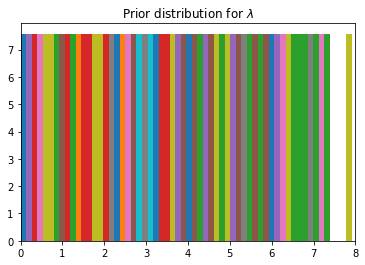

In [8]:
with pm.Model() as model:
    lambda_1 = pm.Exponential('lambda_1', 1)


samples = [lambda_1.random() for i in range(10000)]
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda$")
plt.xlim(0, 8);

PyMC3 stochastic variables have a keyword argument *observed*. The keyword *observed* has a very simple role: fix the variable's current value to be the given data, typically a NumPY array or pandas DataFrame. For example:

In [9]:
import numpy as np

data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson("fxd", 1, observed = data)
    
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


#### Modeling approaches

A good starting thought to Bayesian modeling is to think about *how your data might have been generated*. Position yourself in an omniscient position, and try to imagine how you would recreate the dataset.

> Probabilistic programming will unlock narrative explanations of data, one of the holy grails of business analytics and the unsung hero of scientific persuasion. People think in terms of stories - thus the unresonaable power of the anecdote to drive decision-making, well-founded or not. But existing analytics largely fails to provide this kind of story; instead, numbers seemingly appear out of thin air, with little of the causal context that humans prefer when weighing their options.

#### Same story; different ending.

Interestingly we can create a new datasets by retelling the story. For example, if we reverse the above steps, we can simulate a possible realization of the dataset.

1) Specify when the user's behaviour switches by sampling from $\text{DiscreteUniform(0, 80)}$:

In [10]:
tau = np.random.randint(0, 80)
print(tau)

20


2) Draw $\lambda_1$ and $\lambda_2$ from an $\text{Exp}(\alpha)$ distribution:

In [11]:
alpha = 1./20
lambda_1, lambda_2 = np.random.exponential(scale = 1/alpha, size = 2)
print(lambda_1, lambda_2)

30.273222277315067 18.778146693873527


3) For days before $\tau$, represent the user's received SMS count by sampling from $\text{Poi}(\lambda_1)$, and sample from $\text{Poi}(\lambda_2)$ for days after $\tau$

In [12]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), 
             stats.poisson.rvs(mu=lambda_2, size=80-tau)]

4) Plot the artificial dataset:

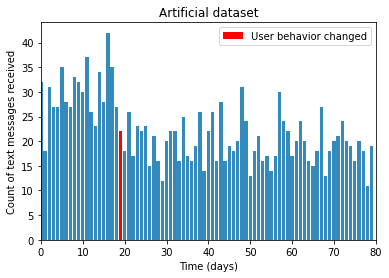

In [13]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau-1], color="r", label="User behavior changed")
plt.xlabel('Time (days)')
plt.ylabel('Count of text messages received')
plt.title('Artificial dataset')
plt.xlim(0, 80)
plt.legend()

PyMC3's engine is designed to find good parameters, $\lambda_i,\; \tau$ that maximize the probability of having observed dataset.

The ability to generate artificial dataset is an interesting side effect of our modeling, and we will see that this ability is a very important method of Bayesian inference.

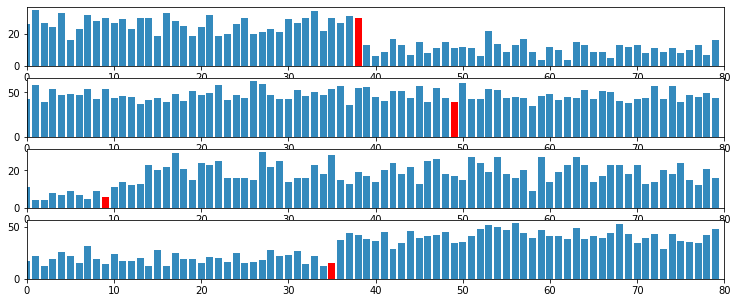

In [14]:
def plot_artificial_sms_dataset():
    tau = np.random.randint(0, 80)
    alpha = 1./20
    lambda_1, lambda_2 = stats.expon.rvs(scale = 1/alpha, size = 2)
    data = np.r_[stats.poisson.rvs(mu = lambda_1, size = tau), 
                 stats.poisson.rvs(mu = lambda_2, size = 80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau-1, data[tau-1], color="r", label="User behavior changed")
    plt.xlim([0, 80])
    
plt.figure(figsize=(12.5, 5))
plt.title('More example of artificial datasets')
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

#### Example: A/B testing

Assume that there is some $0 < p_A < 1$ probability that users who, upon shown site A, eventually purchase from the site. This is the true effectiveness of site A. This quantity is unknown to us.

Suppose site A is shown to $N$ people, and $n$ people purchased from the site. One might concludes hastily that $p_A = \frac{n}{N}$. Unfortunately, the *observed frequency* $ \frac{n}{N} $ does not necessarily equal $p_A$ -- there is a difference between the *observed frequency* and the *true frequency* of an event. 

The true frequency of events are common requests we ask of Nature. Unfortunately, often Nature hides the true frequency from us and we must infer it from observed data.

We are interested in using what we know: $N$, $n$ to estimate $p_A$. To setup a Bayesian model, we need to assign prior distributions to our unknown quantities, A *priori*, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [15]:
with pm.Model() as model:
    p = pm.Uniform('p', lower = 0, upper = 1)

Had we had stronger beliefs, we could have expressed them in the prior above.

For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or note. To simulate this from $N$ trials, we use a *Bernoulli* distribution: if $X \sim \text{Ber }(p)$ then $X$ is 1 with probability $p$ and 0 with probability $1 - p$.

In [16]:
p_true = 0.05
N = 3000

occurrences = stats.bernoulli.rvs(p_true, size = N)

print(occurrences)
print(np.sum(occurrences))

[0 0 0 ... 0 0 0]
167


We could check the equalness of *observed frequency* and the *true frequency*

In [17]:
print("Observed frequency: {}".format(np.sum(occurrences) / N))
print("Does this frequency equal the true frequency: {}"
      .format(np.mean(occurrences) == p_true))

Observed frequency: 0.05566666666666667
Does this frequency equal the true frequency: False


We combine the observation into the PyMC3 observed variable, and run our inference algorithm:

In [18]:
with pm.Model() as model:
    p = pm.Uniform('p', lower = 0, upper = 1)
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    step = pm.Metropolis()
    trace = pm.sample(18000, step = step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 1_000 tune and 18_000 draw iterations (4_000 + 72_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


We plot the posterior distribution of the unknown $p_A$ below:

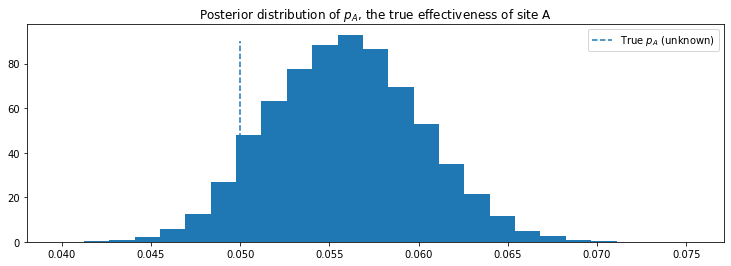

In [19]:
plt.figure(figsize=(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="True $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", density=True)
plt.legend()

Our posterior distribution puts more weight near the true value of $p_A$, but also some weigths in the tails. This is a measure of how uncertain we should be.

#### A and B Together

A similar analysis can be done for site B's response data to determine the analogous $p_B$, but we are interested in the difference between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$ and $\Delta = p_A - p_B$, all at once (We will assume for this exercise that $p_B = 0.04$, so $\Delta = 0.01 \text{, } N_B = 750$

In [20]:
# These 2 quantities are unknown to us.
true_p_A = 0.06
true_p_B = 0.03

# Unequal sample sizes -- No problem in Bayesian analysis
N_A = 1500
N_B = 1500

# Generate some observations
observationA = stats.bernoulli.rvs(true_p_A, size = N_A)
observationB = stats.bernoulli.rvs(true_p_B, size = N_B)

print(np.mean(observationA))
print(np.mean(observationB))

0.068
0.029333333333333333


In [21]:
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function
    delta = pm.Deterministic("delta", p_A - p_B)
    
    # Set of observations, in this case we have 2 observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed = observationA)
    obs_B = pm.Bernoulli("obs_B", p_B, observed = observationB)
    
    step = pm.Metropolis()
    trace = pm.sample(20000, step = step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


We plot the posterior distributions for the three unknowns:

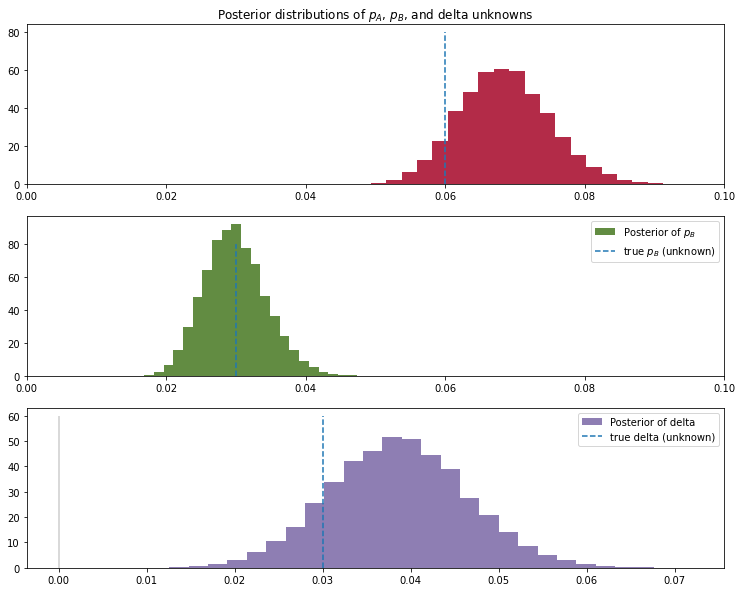

In [22]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

plt.figure(figsize=(12.5, 10))

# histogram of posteriors
ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype="stepfilled", bins=25, alpha=0.85, 
         label="Posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyles="--", label="true $p_A$ (unknown)")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype="stepfilled", bins=25, alpha=0.85, 
         label="Posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyles="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)

plt.hist(delta_samples, histtype="stepfilled", bins=30, alpha=0.85, 
         label="Posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyles="--", label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right")


as a result of N_B < N_A, i.e. we have less data from site B, our posterior distribution of $p_B$ is fatter, implying that we are less certain about the true value of $p_B$ than we are of $p_A$.

The majority of the distribution is above delta = 0, implying that site A's response if likely better than site B's response. The probability this inference is incorrect is easily computable:

In [23]:
print("Probability site A is WORSE than site B: {}"
       .format(np.mean(delta_samples < 0)))
print("Probability site A is BETTER than site B: {}"
       .format(np.mean(delta_samples > 0)))

Probability site A is WORSE than site B: 0.0
Probability site A is BETTER than site B: 1.0


#### An algorithm for Human deceit

Social data has an additional layer of interests as people are not always honest with responses. To present an elegant solution to circumventing this dishonesty problem, and to demonstrate Bayesian modeling, we first need to introduce the binomial distribution

##### The Binomial Distribution

The binomial distribution has 2 parameters: N, a positive integer representing N trials or number of instances of potential events, and p, the probability of an event occuring in a single trial. Like the Poisson distribution, it is a **discrete distribution**, but unlike the Poisson distribution, it only weights integers from 0 to N.

$$P(X = k) = \binom{N}{k} p^k(1-p)^{N-k}$$

If $X$ is a binomial random variable with parameters $p$ and $N$, denoted $X \sim \text{Bin }(N, p)$, then $X$ is the number of events that occurred in the $N$ trials (obviously $0 \le X \le N$). The larger $p$, the more events are likely to occur. The expected value of a binomial is equal to $N p$

Below we plot the mass probability distribution for varying parameters:

Text(0.5, 1.0, 'Probability mass distributions of binomial random variables.')

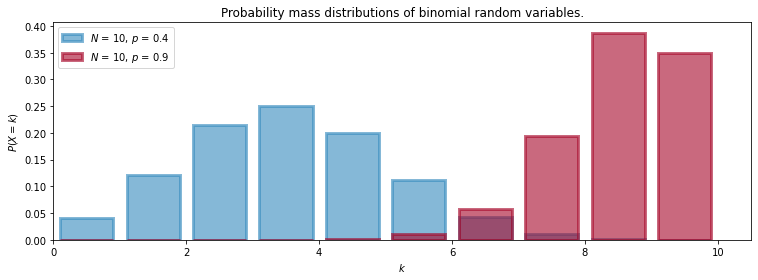

In [24]:
plt.figure(figsize=(12.5, 4))

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, stats.binom.pmf(_x, N, p), color=colors[i], 
            edgecolor = colors[i], alpha = 0.6, 
            label="$N$ = {}, $p$ = {}".format(N, p),
            linewidth = 3)
plt.legend(loc = "upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables.")

The special case when N = 1 corresponds to the Bernoulli distribution. If we have $X_1, X_2, \dots, X_n$ Bernoulli random variables with the same $p$, then $Z = X_1 + X_2 + \dots + X_N \sim \text{Binomial }(N, p)$

#### Example: Cheating among students

We will use binomial distribution to determine the frequency of students cheating during an exam. The following algorithm is a solution to gather answers from students:

> In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answers "Yes, I did cheat" if the coin flips lands heads, and "No, I did not cheat", if the coin flip lands tails. This way, the interviewer does not know if a "Yes was the result of guilty plea, or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers.

The researchers can disard approximately half of their original dataset since half of the response will be noise. They, however, have a systematic data generation process that can be modeled.

Suppose 100 students are being surveyed for cheating, and we wish to find $p$, the proportion of cheaters. Since we are quite ignorant about $p$, we will assign it a **Uniform(0,1)** prior.

Again, thinking of our data-generation model, we assign Bernoulli random variables to the 100 students: 1 implies they cheated and 0 implies they did not.

In [25]:
N = 100
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    true_answers= pm.Bernoulli("truths", p, shape = N, 
                               testval=np.random.binomial(1, 0.5, N))
    first_coin_flips = pm.Bernoulli("first_flips",  0.5, shape = N, 
                                    testval=np.random.binomial(1, 0.5, N))
print(first_coin_flips.tag.test_value)

[1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1
 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1]


Although not everyone flips a second time, we can still model the possible realization of second coin flips:

In [26]:
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, 
                                     testval=np.random.binomial(1,0.5,N))

Using these variables, we can return a possible realization of the *observed proportion* of "Yes" responses.

In [27]:
import theano.tensor as tt
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips) * second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", 
                                           tt.sum(val)/float(N))    

The line fc*t_a + (1 - fc)*sc contains the heart of the *Privacy algorithm*. Elements in this array are 1 if and only if

* i) the first toss is heads and the student cheated
* ii) The second is heads, and are 0 else.

The last line sums this vector and divides by float(N), produces a proportion

In [28]:
observed_proportion.tag.test_value

array(0.44)

Next we need a dataset. After performing our coin-flipped interviews the researchers received 35 "Yes" response. To put this into a relative perspectie, If there truly were no cheaters, we should expect to see on average 1/4 of all responses being a "Yes" (half chance of having first coin land Tails, and another half chance of having second coin land Heads), so about 25 responses in a cheat free world. On the other heand, if *all students cheated*, we should expected to see approximately 3/4 of all responses be Yes.

The researchers observe a Binomial random variable, with N = 100, and p = observed_proportion with value = 35:

In [29]:
X = 35

with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed = X)

Below we add all the variables of interest to a *Model* container and run our black-box algorithm over the model

In [30]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 995 seconds.
The number of effective samples is smaller than 10% for some parameters.


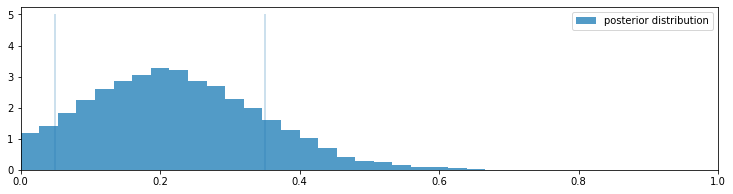

In [33]:
plt.figure(figsize=(12.5, 3))
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30,
        label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha = 0.3)
plt.xlim(0,1)
plt.legend()

We are still pretty uncertain about what the true frequency of cheaters might be, but we have narrowed it down to a range between 0.05 to 0.35. This is pretty good as a *priori* we had no idea how many students might have cheated

We discovered something. It is implausible that there are *no* cheaters, i.e. the posterior assigns low probability p = 0. Since we started with an uniform prior, treating all values of $p$ as equally plausible, but the data ruled out p = 0 as a possibility, we can be confident that there were cheaters.

This kind of *Privacy algorithm* can be used to gather private information from users and be *reasonably* confident that the data, though noise, is truthful.

#### Alternative PyMC3 Model

Given a value of $p$, we can find the probability the student will answer yes:

$$ 
\begin{split}
P(\text{"Yes"}) &= P(\text{Heads on first coin})P(\text{cheater}) + P(\text{Tails on first coin})P(\text{Heads on second coin}) \\
&= \frac{1}{2}p + \frac{1}{2}\frac{1}{2} \\
&= \frac{p}{2} + \frac{1}{4}
\end{split}
$$

Thus, knowing $p$ we know the probability a student will respond "Yes". In PyMC3, we can create a deterministic function to evaluate the probability of responding "Yes", given $p$:

In [34]:
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)

If we know the probability of respondents saying "Yes", which is p_skewed, and we have N = 100 students, the number of "Yes" responses is a binomial random variable with parameters N and p_skewed.

This is where we include our observed 35 "Yes" responses. In the declaration of the pm.Binomial, we include value = 35 and observed = True.

In [35]:
with model:
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed = 35)    

We add all the variables of interest to a Model container and run our black-box algorithm over the model.

In [36]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(25000, step = step)
    burned_trace = trace[2500:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [freq_cheating]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


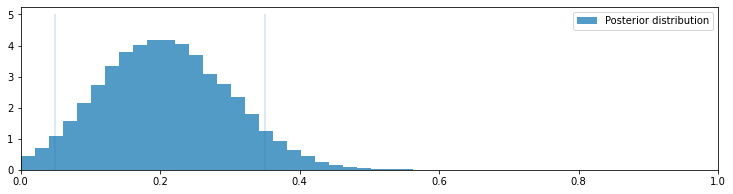

In [38]:
plt.figure(figsize=(12.5, 3))
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha = 0.85, bins = 30, 
         label="Posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha = 0.2)
plt.xlim(0, 1)
plt.legend()

#### More PyMC3 Tricks

**Protip: Arrays of PyMC3 variables**

we can store multiple heterogeneous PyMC3 variables in a Numpy array. Just remember to set the dtype of the array to object upon initialization. For example:

In [39]:
N = 10
x = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential('x_{}'.format(i), (i+1)**2)

Some practical examples of PyMC3 and PyMC3 modeling:

#### Example: Challenger Space Shuttle Disaster

On January 28, 1986, the 25th flight of the US space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidental commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-ring on 23, (one was lost at sea) and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend.

Temp (F), O-Ring failure
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


Text(0.5, 1.0, 'Defects of the Space Shuttle O-Rings vs temperature')

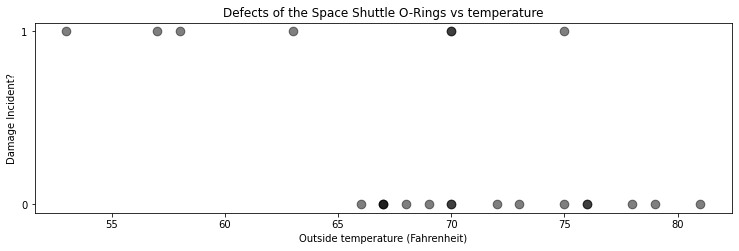

In [40]:
plt.figure(figsize=(12.5, 3.5))
np.set_printoptions(precision=3, suppress=True)
challenger_oring = np.genfromtxt('data/challenger_oring.csv', skip_header=1,
                                usecols=[1,2], missing_values="NA", delimiter=",")

# Drop the NA values
challenger_oring = challenger_oring[~np.isnan(challenger_oring[:,1])]

# Plot it as a function of temperature
print("Temp (F), O-Ring failure")
print(challenger_oring)

plt.scatter(challenger_oring[:, 0], challenger_oring[:, 1], s = 75, color="k",
            alpha = 0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature")

It looks clear that the *probability* of damage incidents occuring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occuring. The best we can do is ask: "At temperature $t$, what is the probability of a damage incident?"

We choose *logistic function* to model $p(t)$

$$ p(t) = \frac{1}{1 + e^{\beta t}}$$

$\beta$ is the variable we are uncertain about. Below is the function plotted for $\beta = 1, 3, -5$

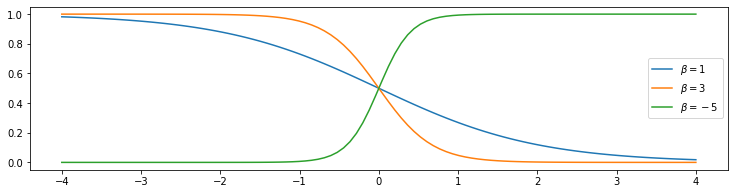

In [41]:
plt.figure(figsize=(12.5, 3))
logistic = lambda x, beta: 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend()

The probability changes only near zero, but in our data above, the probability changes around 65 to 70. We need to add a bias term to our logistic function:

$$ p(t) = \frac{1}{1 + e^{\beta t + \alpha}}$$

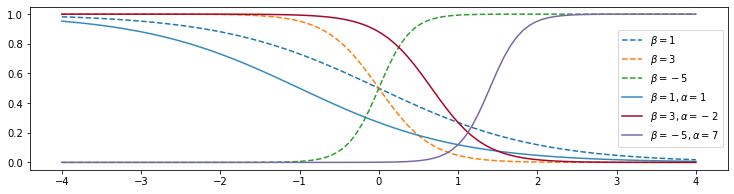

In [42]:
plt.figure(figsize=(12.5, 3))
logistic = lambda x, beta, alpha=0: 1.0 / (1.0 + np.exp(beta * x + alpha))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--")

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$", color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$", color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$", color="#7A68A6")

plt.legend()

Adding a constant $\alpha$ term shifting the curve left or right.

### Normal Distributions

A Normal random variable denoteed $X \sim N(\mu, 1/\tau)$, has a distribution with 2 parameters: the mean, $\mu$ and the *precision* $\tau$. The smaller $\tau$, the larger the spread of the distribution (i.e. we are more uncertain); the larger $\tau$, the tighter the distribution (i.e. we are more certain). $\tau$ is always positive.

The probability density function of a $N(\mu, 1/\tau)$ random variable is:

$$ f(x|\mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \text{exp }\Big(-\frac{\tau}{2}(x-\mu)^2\Big) $$

We plot some different density functions below:

Text(0.5, 1.0, 'Probability distribution of three different Norm random variables')

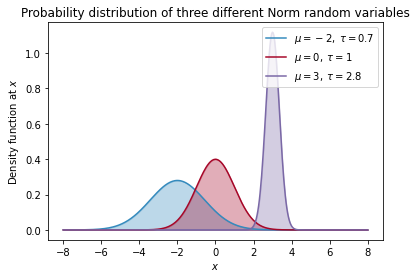

In [43]:
norm = stats.norm
x = np.linspace(-8, 8, 400)
mu = (-2,  0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, norm.pdf(x, _mu, scale = 1./_tau), 
            label="$\mu = {}, \;\\tau = {}$".format(_mu, _tau), color=_color)
    plt.fill_between(x, norm.pdf(x, _mu, scale=1./_tau), color=_color, alpha=.33)
    
plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("Density function at $x$")
plt.title("Probability distribution of three different Norm random variables")

A Normal random variable can be taken on any real number, but the variable is likely to be relatively close to $\mu$

$$ E[X | \mu, \tau] = \mu $$

And its variance is equal to the inverse of $\tau$:

$$ \text{Var }(X | \mu, \tau) = \frac{1}{\tau} $$

We continue our modeling of the Challenger space craft:

In [44]:
temperature = challenger_oring[:, 0]
D = challenger_oring[:, 1] # defect or not?

with pm.Model() as model:
    beta = pm.Normal("beta", mu = 0, tau = 0.001, testval = 0)
    alpha = pm.Normal("alpha", mu = 0, tau = 0.001, testval = 0)
    p = pm.Deterministic("p", 1.0 / (1. + tt.exp(beta * temperature + alpha)))

We connect them to our observed data by using a Bernoulli random variable with parameter $p$, denoted $\text{Bernoulli }(p)$ is a random variable that takes value 1 with probability $p$ and 0 else. 

In [45]:
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step = step, start = start)
    burned_trace = trace[100000::2]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


Sampling 4 chains for 1_000 tune and 120_000 draw iterations (4_000 + 480_000 draws total) took 78 seconds.
The number of effective samples is smaller than 10% for some parameters.


We have trained our model on the observed data, now we can sample values from the posterior. Let's look at the posterior distributions for $\alpha$ and $\beta$.

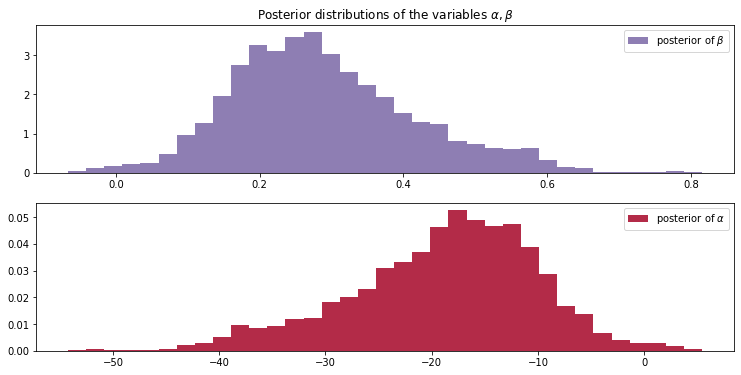

In [48]:
alpha_samples = burned_trace["alpha"][:, None]
beta_samples = burned_trace["beta"][:, None]

plt.figure(figsize=(12.5, 6))

plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype="stepfilled", bins=35, alpha=0.85, 
         label=r"posterior of $\beta$", color="#7A68A6", density=True)
plt.legend()
plt.subplot(212)
plt.hist(alpha_samples, histtype="stepfilled", bins=35, alpha=0.85, 
         label=r"posterior of $\alpha$", color="#A60628", density=True)
plt.legend()

All samples of $\beta$ are greater than 0. All $\alpha$ posterior values are negative and far away from 0. 

Regarding the spread of the data, we are very uncertain about what the true parameters might be (though considering the low sample size and the large overlap of defects-to-nondefects this behavior is expected)

we look at the expected probability for a specific value of the temperature.

Text(0.5, 0, 'Temperature')

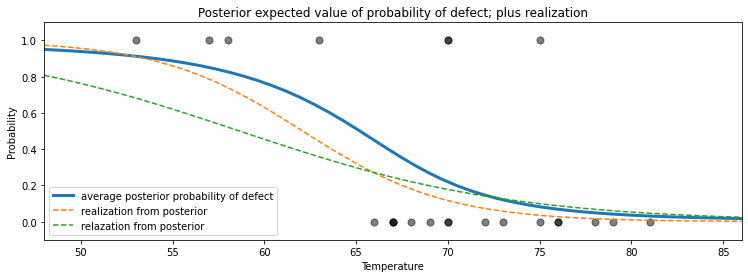

In [49]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

plt.figure(figsize=(12.5, 4))

plt.plot(t, mean_prob_t, lw=3, label="average posterior probability of defect")
plt.plot(t, p_t[0,:], ls="--", label="realization from posterior")
plt.plot(t, p_t[-3, :], ls="--", label="relazation from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; plus realization")
plt.legend(loc="lower left")
plt.ylim(-.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("Probability")
plt.xlabel("Temperature")

The blue line is what occurs when we average all the 20000 possible dotted lines.

One interesting question to ask is for what temperatures are we most uncertain about the defect-probability? We plot the expected value line and the associated 95% for each temperature.

Text(0.5, 1.0, 'posterior probability estimates given temp. $t$')

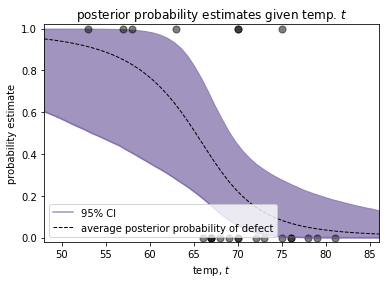

In [50]:
from scipy.stats.mstats import mquantiles

qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=.7, color="#7A68A6")

plt.plot(t[:,0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)
plt.plot(t, mean_prob_t, lw=1, ls="--", color="k", 
         label="average posterior probability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("posterior probability estimates given temp. $t$")

#### What about the day of the Challenger disaster?

On the day of the Challenger disaster, the ouside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occuring, given this temperature.

Text(0.5, 0, 'Probability of defect occuring in O-ring')

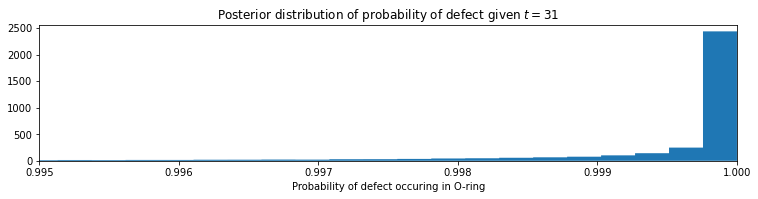

In [53]:
plt.figure(figsize=(12.5, 2.5))

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=4000, density=True, histtype="stepfilled")
plt.title("Posterior distribution of probability of defect given $t = 31$")
plt.xlabel("Probability of defect occuring in O-ring")

### Is our model appropriate?

How do we know our model is an expression of the data? This encourages us to measure the model's **goodness of fit**.

We can think: *how can we test whether our model is a bad fit?* An idea is to compare observed data with artificial dataset which we can simulate. The rationale is that if the simulated dataset does not appear similar, statistically, to the observed dataset, then likely our model is not accurately represented the observed data.

Let's simulate 10000:

In [54]:
N = 10000
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    simulated = pm.Bernoulli("bernoulli_sim", p, shape=p.tag.test_value.shape)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(N, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>BinaryGibbsMetropolis: [bernoulli_sim]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 19 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


(40000, 23)


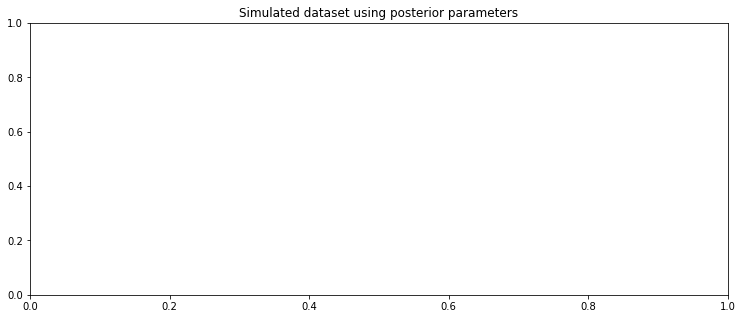

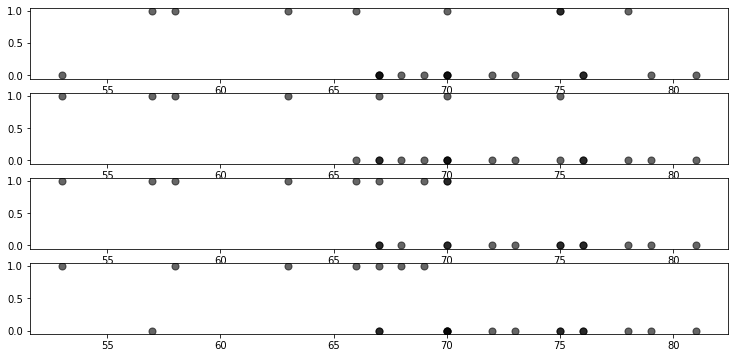

In [55]:
plt.figure(figsize=(12.5, 5))

simulations = trace["bernoulli_sim"]
print(simulations.shape)

plt.title("Simulated dataset using posterior parameters")
plt.figure(figsize=(12.5, 6))
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature, simulations[1000*i, :], color="k", s=50, alpha=0.6)

For each model, we calculate the porportion of times the posterior simulation proposed a value of 1 for a particular temperature, i.e. compute $P(\text{Defect } = 1 | t, \alpha, \beta$ by averaging. This gives us the posterior probability of a defect at each data point in our dataset

In [56]:
posterior_probability = simulations.mean(axis=0)
print("Posterior prob of defect | realized defect")
for i in range(len(D)):
    print("%.2f  |  %d" % (posterior_probability[i], D[i]))

Posterior prob of defect | realized defect
0.43  |  0
0.23  |  1
0.27  |  0
0.32  |  0
0.38  |  0
0.16  |  0
0.14  |  0
0.23  |  0
0.82  |  1
0.60  |  1
0.23  |  1
0.06  |  0
0.37  |  0
0.89  |  1
0.37  |  0
0.10  |  0
0.23  |  0
0.04  |  0
0.08  |  0
0.05  |  0
0.10  |  1
0.08  |  0
0.80  |  1


In [57]:
ix = np.argsort(posterior_probability)
for i in range(len(D)):
    print("%.2f  |  %d" % (posterior_probability[ix[i]], D[ix[i]]))

0.04  |  0
0.05  |  0
0.06  |  0
0.08  |  0
0.08  |  0
0.10  |  0
0.10  |  1
0.14  |  0
0.16  |  0
0.23  |  1
0.23  |  0
0.23  |  1
0.23  |  0
0.27  |  0
0.32  |  0
0.37  |  0
0.37  |  0
0.38  |  0
0.43  |  0
0.60  |  1
0.80  |  1
0.82  |  1
0.89  |  1


Text(0, 0.5, '$\\beta$')

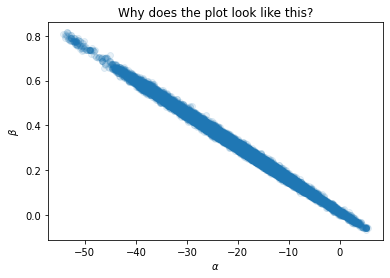

In [58]:
plt.scatter(alpha_samples, beta_samples, alpha=.1)
plt.title("Why does the plot look like this?")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")